In [1]:
!pip install sentence_transformers datasets pip install langchain -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.7/600.7 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 84.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 71.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 11.8 MB/s eta 0:00

In [2]:
!nvidia-smi

Fri Apr 21 08:30:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    46W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
seed=0
from tqdm import tqdm
tqdm.pandas()

import numpy as np
import pandas as pd
from langchain.embeddings import HuggingFaceEmbeddings
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
from torch import nn

import matplotlib.pyplot as plt

from IPython.display import clear_output 

In [4]:
!nvidia-smi -L

GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-8941f973-d935-7baa-9c76-4a9071523b86)


In [5]:
from datasets import load_dataset

dataset = load_dataset("quora", split="train")
dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/404290 [00:00<?, ? examples/s]

Dataset quora downloaded and prepared to /root/.cache/huggingface/datasets/quora/default/0.0.0/36ba4cd42107f051a158016f1bea6ae3f4685c5df843529108a54e42d86c1e04. Subsequent calls will reuse this data.


Dataset({
    features: ['questions', 'is_duplicate'],
    num_rows: 404290
})

In [6]:
dataset[0]

{'questions': {'id': [1, 2],
  'text': ['What is the step by step guide to invest in share market in india?',
   'What is the step by step guide to invest in share market?']},
 'is_duplicate': False}

In [7]:
sampled_dataset = dataset.shuffle(seed=seed).select(range(400000))

data = []
for d in tqdm(sampled_dataset):
    data.append((d["questions"]["text"][0], d["questions"]["text"][1], int(d["is_duplicate"])))
clear_output()

df = pd.DataFrame(data, columns=["sentence1", "sentence2", "label"])
df.head()

,sentence1,sentence2,label
0,What skills would a Chinese programmer need to...,What are the qualities(competetive as well as ...,0
1,Why is the respect of cultural diversity impor...,Why does diversity matter?,0
2,How do I turn off 'quoted' purple text in Gmail?,"Do Gmail recipients also see the purple, unedi...",0
3,How do I find out which people I am following ...,How can I see who's following me on Instagram?,0
4,Where can I download ANSYS for free online?,How do I download Ansys 16.2 For windows 10 th...,0


In [8]:
df.sentence1 = df.sentence1.apply(lambda x: "query: "+x)
df.sentence2 = df.sentence2.apply(lambda x: "query: "+x)
df.head()

,sentence1,sentence2,label
0,query: What skills would a Chinese programmer ...,query: What are the qualities(competetive as w...,0
1,query: Why is the respect of cultural diversit...,query: Why does diversity matter?,0
2,query: How do I turn off 'quoted' purple text ...,query: Do Gmail recipients also see the purple...,0
3,query: How do I find out which people I am fol...,query: How can I see who's following me on Ins...,0
4,query: Where can I download ANSYS for free onl...,query: How do I download Ansys 16.2 For window...,0


In [9]:
df.label.value_counts()

0    252273
1    147727
Name: label, dtype: int64

In [10]:
n = 100000
df = df.groupby("label").apply(lambda x: x.sample(n, random_state=42)).reset_index(drop=True).sample(frac=1, random_state=42)
df.label.value_counts()

1    100000
0    100000
Name: label, dtype: int64

In [11]:
train_size = 0.8
train, test = train_test_split(df, train_size=train_size, random_state=seed)

train.label.value_counts(), test.label.value_counts()

(0    80017
 1    79983
 Name: label, dtype: int64,
 1    20017
 0    19983
 Name: label, dtype: int64)

In [12]:
model_name = 'intfloat/e5-small'
encoder = HuggingFaceEmbeddings(model_name=model_name)

# from langchain.embeddings import CohereEmbeddings
# cohere = CohereEmbeddings(model="medium", cohere_api_key="my-api-key")

# from langchain.embeddings import OpenAIEmbeddings
# openai = OpenAIEmbeddings(openai_api_key="my-api-key")

# More options here
# https://python.langchain.com/en/latest/reference/modules/embeddings.html

vec = encoder.embed_documents(["This is a test sentence", "This is another test sentence"])
clear_output()
shape = np.array(vec).shape
dim = shape[1]
print(shape, dim)

(2, 384) 384


In [13]:
# train a siamese network which takes two sentences as input and outputs a similarity score. Encoder is frozen. Encode dim is 384.
# encodings1 -> dropout - > dense1 -> dropout -> dense2 -> updated encodings1
# encodings2 -> dropout - > dense1 -> dropout -> dense2 -> updated encodings2
# cosine similarity between updated encodings
# loss = MSE(label - cosine similarity)

device = "cuda"

class Model(torch.nn.Module):
    def __init__(self, encoder, dim, dropout=0.2):
        super(Model, self).__init__()
        self.encoder = encoder
        self.dropout = torch.nn.Dropout(dropout)
        self.dense1 = torch.nn.Linear(dim, dim)
        self.dense2 = torch.nn.Linear(dim, dim)
        self.cosine = torch.nn.CosineSimilarity(dim=1)
        
    def block(self, sentences):
        encodings = self.encoder.embed_documents(sentences)
        encodings = torch.tensor(encodings).to(device)
        encodings = self.dropout(encodings).to(device)
        encodings = self.dense1(encodings)
        encodings = self.dropout(encodings)
        encodings = self.dense2(encodings)
        return encodings
    
    def forward(self, sentences1, sentences2):
        encodings1 = self.block(sentences1)
        encodings2 = self.block(sentences2)
        sim = self.cosine(encodings1, encodings2).cpu()
        return sim

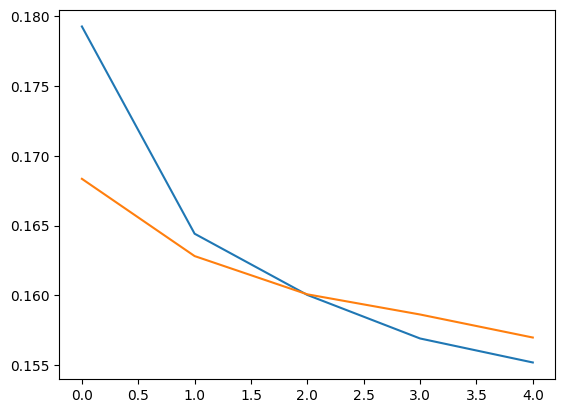

In [14]:
BATCH_SIZE = 256
train_losses = []
test_losses = []

model = Model(encoder, dim)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss = nn.MSELoss()

for epoch in range(0,5):
    epoch += 1
    print("Epoch: ", epoch)
    epoch_train_losses = []
    for i in tqdm(range(0, len(train), BATCH_SIZE), total=len(train)//BATCH_SIZE):
        #training
        batch = train.iloc[i:i+BATCH_SIZE]
        
        sentences1 = batch.sentence1.tolist()
        sentences2 = batch.sentence2.tolist()
        labels = torch.tensor(batch.label.values).type(torch.FloatTensor)
        
        sim = model(sentences1, sentences2)
        loss = torch.nn.functional.mse_loss(sim, labels)
        epoch_train_losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss = torch.tensor(epoch_train_losses).mean()
    train_losses.append(train_loss)
    print("Train loss: ", train_loss)
        
    # evaluation
    with torch.no_grad():
        sentences1 = test.sentence1.tolist()
        sentences2 = test.sentence2.tolist()
        labels = torch.tensor(test.label.values).type(torch.FloatTensor)
        
        sim = model(sentences1, sentences2)
        loss = torch.nn.functional.mse_loss(sim, labels)
        test_losses.append(loss)
    
        print("Test loss: ", loss.item())
    clear_output()
    plt.plot(range(epoch), train_losses)
    plt.plot(range(epoch), test_losses)
    plt.show()

In [21]:
pred_label = [1 if s>0.55 else 0 for s in sim]
print(classification_report(test.label.values, pred_label))

              precision    recall  f1-score   support

           0       0.78      0.80      0.79     19983
           1       0.80      0.77      0.78     20017

    accuracy                           0.79     40000
   macro avg       0.79      0.79      0.79     40000
weighted avg       0.79      0.79      0.79     40000



In [19]:
encodings1 = model.encoder.embed_documents(test.sentence1.tolist())
encodings2 = model.encoder.embed_documents(test.sentence2.tolist())
sim_encoder = model.cosine(torch.tensor(encodings1), torch.tensor(encodings2)).cpu()
pred_label = [1 if s>0.95 else 0 for s in sim_encoder]
print(classification_report(test.label.values, pred_label))

              precision    recall  f1-score   support

           0       0.74      0.83      0.78     19983
           1       0.80      0.70      0.75     20017

    accuracy                           0.77     40000
   macro avg       0.77      0.77      0.77     40000
weighted avg       0.77      0.77      0.77     40000

